In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, MeanShift, SpectralClustering, AffinityPropagation
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
import gc

In [3]:
df = pd.read_csv('docs.csv').sample(frac=1, random_state=0) #shuffle rows
df.index = range(0, 100) #reindex

## The Dataset
I've grabbed chapters and various labels from the text:

In [8]:
print(len(df))
df.head()

100


,text,title,author,date,fiction,lengths
0,"\n He fixed things--clocks, refrigerators, ...",variableman,dick,1953,1,1106
1,\nGramps missed none of the high drama he had ...,trip_up_yonder,vonnegut,1953,1,880
2,\nThe swaying had come to a halt and it was da...,youth,asimov,1952,1,1155
3,\nThey gave him a gold watch. It was meant to ...,spaceman_spree,reynolds,1963,1,758
4,"\n""Conseil,"" I called in an impatient voice.\n...",20000leagues,verne,1870,1,801


In [6]:
#And the author classes are mostly balanced. 
#Vonnegut only has two short stories under the public license,
#so his class is a little smaller than the others.
df.author.value_counts()

pohl        11
verne       11
asimov      11
wells       11
dick        10
herbert     10
rockwell    10
bradbury    10
reynolds    10
vonnegut     6
Name: author, dtype: int64

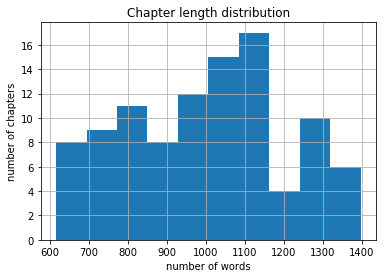

In [28]:
#There is a bit of variance in the number of words for each sample, too. They vary between 600 and 1400 words.
df.lengths.hist()
plt.title('Chapter length distribution');
plt.xlabel('number of words')
plt.ylabel('number of chapters')
plt.show();

## Holdout group
Reserving 25% of the samples for holdout group.

In [12]:
train = df.loc[:74].copy() #train grou, 75 samples
test = df.loc[75:].copy() #holdout group
len(test)

25

## Parsing
Using spacy to sparse the data.

In [13]:
prs = spacy.load('en')

In [14]:
train['raw_parse'] = train.text.apply(prs)

In [15]:
def get_lemmas(document):
    """takes raw spacy parse and returns only
    word lemmas, in or out of vocab.
    """
    result = ''
    for token in document:
        if not token.is_space and not token.is_punct and not (token.lemma_ == '-PRON-'):
            result += token.lemma_ + ' '
        elif token.lemma_ == '-PRON-':
            result += token.orth_ + ' '
    return result

In [16]:
train['lemmas'] = train.raw_parse.apply(get_lemmas)

## Vectorize
Using tfidf to vectorize

In [17]:
vec = TfidfVectorizer(stop_words='english', min_df=2, max_df=.99, ngram_range=(1, 3))
vec.fit(train.lemmas)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.99, max_features=None, min_df=2,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [18]:
train_mat = vec.transform(train.lemmas)

## Basic attempt at clustering
used SVD to cluster. It was kind of interesting how these four clusters appear when I just use two components:

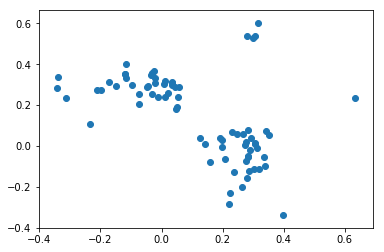

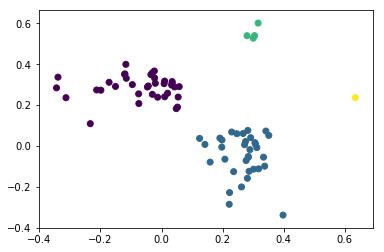

In [21]:
svd = TruncatedSVD(n_components=2, random_state=0)
train_trans = svd.fit_transform(train_mat).reshape(2, 75)
c1 = train_trans[0]
c2 = train_trans[1]

train['c1'] = c1
train['c2'] = c2

plt.scatter(c1, c2)
plt.show();

mshift = MeanShift(bandwidth=.2)
train['mshift'] = mshift.fit_predict(train[['c1', 'c2']])
plt.scatter(train['c1'], train['c2'], c=train['mshift'])
plt.show();

... However, the four clusters don't seem to provide any distinguishing information. between the various labels on the data.

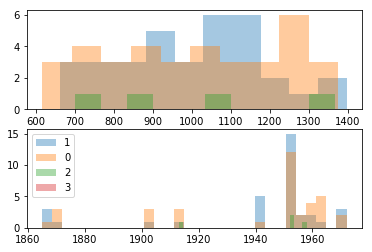

In [22]:
fig, ax = plt.subplots(2)
for clust in train.mshift.unique():
    ax[0].hist(train[train['mshift']==clust].lengths, alpha=.4, label=str(clust))
    ax[1].hist(train[train['mshift']==clust].date, alpha=.4, label=str(clust), bins=30)
plt.legend();
plt.show();

## Predicting authors with cluster features (doesn't really work yet.)

In [ ]:
# I ran this gridsearch across a number of parameters to try to predict authors. None performed better than 13%.
# This was all a pretty rushed, naive attempt anyway, but I think what's lacking is more features.

In [ ]:
vec = TfidfVectorizer()
trans = TruncatedSVD()
clust = KMeans()
mod = BernoulliNB()

steps = [
    ('vec', vec),
    ('trans', trans),
    ('clust', clust),
    ('mod', mod)
]

pln = Pipeline(steps=steps)

param_grid = {
    'vec__ngram_range': [(1,1), (1,2)],
    'vec__min_df': [3],
    'vec__max_df': [.5, .9],
    'trans__n_components': range(2, 76, 2),
    'clust__n_clusters': range(2, 20, 2),
    'mod__alpha': [1]
}

srch = GridSearchCV(pln, param_grid=param_grid, verbose=2, n_jobs=-1)

In [ ]:
srch.fit(train.lemmas, train.author)
srch.best_score_

In [ ]:
srch.best_params_

In [ ]:
gc.collect()